# 0.운영체제 과제 01
- 201901763 이지호

- 코드 개요 : 
    
    1. 각 스케쥴링 방법에서, json 파일을 받아온 다음에 속성들을 파악해 스케쥴링 함. 이후 order라는 list로 "몇 번 프로세스를 얼마 동안 실행해라" 를 전달하고 draw()로 간트차트 그래픽 출력함.
    2. JSON_NUM : 숫자를 바꿔가며 각 파일마다 결정론적 벤치마킹 가능함.
    3. PRINT_FLAG (기본값 false) : True로 변경 시 각 프로세스들의 첫 시작과 첫 종료 시간 출력함.
    4. DEFAULT_QUANTUM_TIME : 기본 퀀텀타임 전역으로 설정가능함. MLQ, MLFQ에서도 각 레벨마다 할당치 재설정 가능함.


- json file 개요 : 
    1. Arrival time, Burst time이 각각 다른 여러 프로세스들.
    2. (1)과 비슷하지만, 도착이 아주 느린 프로세스있으며 전체적으로 Burst time scale 대폭 늘림. (RR에서 퀀텀타임 늘려야 예쁘게 출력됨. 기본 간격 4인데 세자리 burst time 대입해서 너무 조밀하게 보이는 것일 뿐임.)
    3. Rate-monotonic 에서는 Hard RTOS 처리 불가하지만, EDF 스케쥴링 에선 Hard RTOS 성립하는 경우의 의도적 비교 (Hard RTOS 성립 불가 시, 아예 출력하지 않음)

## 1.1. Set Global const Value

In [209]:
import copy
import matplotlib.pyplot as plt
import json

    - _JSON_NUM_
    
    json file 변경해가며 출력 가능

In [210]:
_JSON_NUM_ = 2

    - 입력할 전체 프로세스들의 시간 길이. 스케쥴링 완료 시 이전에 for문 종료


In [211]:
_MAX_TIME_LENGTH_ = 99999

    - Round robin

    퀀텀 타임 설정. 전역에 적용되는 상수인데, RR function parameter에서도 value수정 가능

In [212]:
_DEFAULT_QUANTUM_TIME_ = 4

    - print flag

    해당 플래그 True로 바꾸면, 모든 프로세스들의 최초 실행 시 정상 시작 - 정상 종료 여부 출력함

In [213]:
_PRINT_FLAG_ = False
# _PRINT_FLAG_ = True

    - complete flag

In [214]:
_COMPLETE_ = 0

    - 모든 스케쥴링 결과 저장하는 변수

In [215]:
_result = dict()

## 1.2. Load data

In [216]:
def data_loader():
    print("--Data_loader-----------------")
    _jsonfilename = "case" + str(_JSON_NUM_) + ".json"
    with open(_jsonfilename) as f:
        json_object = json.load(f)

    num_of_processs = len(json_object['list'])
    print("- Num of Process :", num_of_processs)

    # data checking
    assert json_object['list']
    for i in range(num_of_processs):
        assert json_object['list'][i]["Num"] > 0
        assert json_object['list'][i]["Burst_time"] > 0
        assert json_object['list'][i]["Priority"] > 0
        assert json_object['list'][i]["Arrival_time"] >= 0
        assert json_object['list'][i]["Period"] >= 0
    print("- Data Loading Success")

    return json_object

_DATA_ = data_loader()["list"]


--Data_loader-----------------
- Num of Process : 5
- Data Loading Success


## 1.3. Function
### 1.3.1. draw()


#### 1.3.1.1. Color List
- 동일 번호 Process 마다 같은 색으로 시각화 하기 위해 색상표 작성.
- "_COLORS_" 변수 길이 이상의 Process 갯수가 입력 될 시, 랜덤 색상 배정.

In [217]:
_COLORS_ = list(['#F0E68C','#ADD8E6','#FFB6C1','#87CEFA','#66CDAA','#7FFF00','#D2691E','#FF7F50','#6495ED','#00FFFF','#FFFF00','#099099','#00FF00','#FF0000','#FFF8DC','#C0C0C0','#008080','#FFA500','#F0F8FF','#FAEBD7','#7FFFD4','#F0FFFF','#F5F5DC','#FFE4C4','#FFEBCD','#8A2BE2','#A52A2A','#DEB887','#5F9EA0','#008000','#800000','#000080','#808000','#800080','#DC143C','#00008B','#008B8B','#B8860B','#A9A9A9','#006400','#BDB76B','#8B008B','#556B2F','#FF8C00','#9932CC','#8B0000','#E9967A','#8FBC8F','#483D8B','#2F4F4F','#00CED1','#9400D3','#FF1493','#00BFFF','#696969','#1E90FF','#B22222','#FFFAF0','#228B22','#DCDCDC','#F8F8FF','#FFD700','#DAA520','#ADFF2F','#F0FFF0','#FF69B4','#CD5C5C','#4B0082','#0000CD','#BA55D3','#9370DB','#3CB371','#7B68EE','#00FA9A','#48D1CC','#C71585','#191970','#F5FFFA','#FFE4E1','#FFE4B5','#FFDEAD','#FDF5E6','#6B8E23','#FF4500','#DA70D6','#EEE8AA','#98FB98','#AFEEEE','#DB7093','#FFEFD5','#FFDAB9','#CD853F','#FFC0CB','#DDA0DD','#B0E0E6','#BC8F8F','#4169E1','#8B4513','#FA8072','#F4A460','#2E8B57','#FFF5EE','#A0522D','#87CEEB','#6A5ACD','#708090','#FFFAFA','#00FF7F','#4682B4','#D2B48C','#D8BFD8','#FF6347','#40E0D0','#EE82EE','#F5DEB3','#F5F5F5','#9ACD32'])
print("_COLORS_ length is :", len(_COLORS_))

_COLORS_ length is : 117


#### 1.3.1.2. draw Gantt chart
- 프로세스 목록 json 파일 + Order 배열만으로 ploting 일반화 함.
    - ex...
    - Order == [[1, 50], [2, 30], [3, 40]]
    - 1번 프로세스 50, 이후 2번 프로세스 30, 이후 3번 프로세스 40.. 

In [218]:
_ALL_JOB_IS_DONE_ = -999
_NON_PROCESS_ = -1


def draw(_order, _title='', _Displaying=True, _period_vector=[], _jop_complete_alram_vector = []):
    ## set print level
    # nothing
    if (_Displaying == False):
        _PRINT_LEVEL_ = 0
    # all information
    elif (_PRINT_FLAG_ == True):
        _PRINT_LEVEL_ = 2
    # simple information
    else:
        _PRINT_LEVEL_ = 1
    if (_PRINT_LEVEL_ > 0):
        print("- Order :", _order)
    if (_PRINT_LEVEL_ > 1):
        print("--Start Analysis--------------")
        
    # init default variable
    fig, ax = plt.subplots(figsize=(10, 1))
    _process = copy.deepcopy(_DATA_)
    _sum_of_non_busrt_time = 0
    _sum_of_response_time = 0
    _sum_of_turnaround_time = 0
    # _sum_of_running_time = 0
    _now_time = 0
    _cumsum_waiting_time = 0
    _xlim_tickers = []

    # 완전동작 카운터
    _start_counter = 0
    _exit_counter = 0

    for _pid, _runtime in _order:
        # NOT CPU RUNNING
        if (_pid < 0):
            # TAKE A REST
            if (_runtime > 0):
                _now_time += _runtime
                _sum_of_non_busrt_time += _runtime
                continue
            # ALL JOP IS DONE
            elif (_runtime == _ALL_JOB_IS_DONE_):
                break
        # CPU RUNNING
        else:
            # P_num은 1부터 시작하기에, index 맞추는 용도.
            _JUST_PRINT_IDX_ = _pid
            for i in range(len(_process)):
                if (_process[i]['Num'] == _pid):
                    _target = _process[i]
            
            # First come in CPU
            if (_target['Priority'] > 0):
                _sum_of_response_time += _now_time
                if (_PRINT_LEVEL_ > 1):
                    print("START - P", _JUST_PRINT_IDX_, "    time is", _now_time)
                # target의 우선순위에 음수로 시작시간 저장
                # order는 정해져있고, Priority는 이 단계에서 사용하지 않음.
                _target['Priority'] = 0
                _target['Priority'] = - _now_time
                _start_counter += 1
                _xlim_tickers.append(_now_time)
            
            # 통계용 전체 대기 시간 구하기
            _cumsum_waiting_time += _now_time
            
            # ploting
            ax.barh(0, _runtime, left=_now_time,
                    edgecolor='black', color=_COLORS_[_JUST_PRINT_IDX_-1])
            _now_time += _runtime
            ax.text(_now_time - _runtime/2, 0,
                    ('P'+str(_JUST_PRINT_IDX_)), ha='center', va='center')
            _xlim_tickers.append(_now_time)
            
            # 프로세스 정보에서 진행 시간만큼 차감
            # >> 남은 시간만큼 더 스케줄링하면 됨.
            _target['Burst_time'] -= _runtime
            
            # JOP IS DONE ?
            if (_target['Burst_time'] == 0):
                if (_PRINT_LEVEL_ > 1):
                    print(" P", _JUST_PRINT_IDX_, "Turnaround time is",_now_time - _target['Arrival_time'])
                _sum_of_turnaround_time += _now_time - _target['Arrival_time']
                if (_PRINT_LEVEL_ > 1):
                    print(" P", _JUST_PRINT_IDX_, "Running    time is", _now_time -abs(_target['Priority']))
                if (_PRINT_LEVEL_ > 1):
                    print("EXIT  - P", _JUST_PRINT_IDX_, "    time is", _now_time)
                    print("")
                _exit_counter +=1
                
    # is_success?
    if (_PRINT_LEVEL_ > 0):
        print("------------------------------")
        if (_start_counter != len(_process)):
            print("START ERROR.. start fault cnt :", len(_process) - _start_counter)
        else:
            print("ALL START GOOD JOB!!!")
        if (_exit_counter != len(_process)):
            print("EXIT  ERROR.. exit  complete cnt :", len(_process) - _exit_counter)
        else:
            print("ALL EXIT  GOOD JOB!!!")
            
    # ploting
    # _period_vector = [number, period]
    _last_xlim_ticker = _xlim_tickers[-1]
    _RTOS_PLOT_LANGTH_ = 1.2
    # 각 벡터마다 gantt chart 끝까지 주기 티거 생성하기
    if(_period_vector != []):
        for _now_time in range(int(_last_xlim_ticker * _RTOS_PLOT_LANGTH_)):
            _print_ticker = ''
            _draw_flag = False
            for _num, _period in _period_vector:
                # 0초 이상이고, 주기 도래할 때마다 적기
                if (_now_time % _period == 0 and _now_time > 0):
                    # 누구의 period인지?
                    if (_draw_flag == True):
                        _print_ticker = _print_ticker + ','
                    _print_ticker = _print_ticker + str(_num)
                    _draw_flag = True
                    # _xlim_tickers.append(_now_time)
            if (_draw_flag == True):
                ax.text(_now_time, 0.49, '|', ha='center', fontweight='bold')
                ax.text(_now_time, 0.7, ('P'+_print_ticker),
                        ha='center', va='center')
    # x_ticker 중복 제거
    _xlim_tickers = list(set(_xlim_tickers))
    if (_period_vector != []):
        ax.text(0, 0.7, 'Deadline', va='center')
        ax.set_title(_title, y=1.5, ha='center')
        _xlim_tickers = []
        for _ticker in range(int(round(_last_xlim_ticker * _RTOS_PLOT_LANGTH_, -1))):
            if(_ticker % 10 == 0):
                _xlim_tickers.append(_ticker)
        ax.set_xticks(_xlim_tickers)
    else:
        ax.set_title(_title, ha='center')
        ax.set_xticks(_xlim_tickers)
    ax.set_xlim([0, _now_time])
    ax.set_yticks([])
    
    
    if (_PRINT_LEVEL_ > 0):
        plt.show()
    
    _ans = dict()
    # 프로세스를 cpu가 실행하지 않은 평균 대기시간
    _ans['Average_waiting_time'] = _cumsum_waiting_time/len(_process)
    # 처음 대기 부터, 작업 완료에 대한 총 소요 시간 / p's 종료시점 - arrival_time
    _ans['Average_Turnaround_time'] = _sum_of_turnaround_time/len(_process)
    # 프로세스를 처음으로 실행하는 데에 걸린 시간
    _ans['Average_Response_time'] = _sum_of_response_time/len(_process)
    # cpu 이용률
    _ans['CPU_utilization'] = float(
        (_now_time-_sum_of_non_busrt_time)/_now_time*100)
    # 단위 시간당 처리된 프로세스의 개수
    _ans['Throughput'] = len(_process)/_now_time
    # print value
    if (_PRINT_LEVEL_ > 1):
        for _subject, _value in _ans.items():
            if (_subject == 'CPU_utilization'):
                print(_subject, ": %2.2f" % _value, "%")
            elif (_subject == 'Throughput'):
                print(_subject, ": %2.4f" % _value)
            else:
                print(_subject, ":", _value)
    
    return _ans
_list =  copy.deepcopy(_DATA_)

### 1.3.3. is_complete()
- 해당 list에 들은 burst time의 합이 0인지 판단하기


In [219]:
def is_complete(_list):
    _sum_of_all_burst_time = 0
    for i in _list:
        _sum_of_all_burst_time += i['Burst_time']
    if (_sum_of_all_burst_time == 0):
        return True
    else:
        return False

### 1.3.3. order_zip()
- order 압축기
- [5, 1]. [5, 1],..을 [5, 2]로 압축해줌

In [220]:
def order_zip(_order):
    _idx = 0
    while (_idx < len(_order)):
        # 만약 종료 지점 만나면 무한루프 탈출
        if (_order[_idx+1] == [_NON_PROCESS_, _ALL_JOB_IS_DONE_]):
            break
        # 만약 같은 프로세스의 작업지시 만나면 합체
        elif (_order[_idx][0] == _order[_idx + 1][0]):
            _order[_idx + 1][1] += _order[_idx][1]
            _order.pop(_idx)
        # 다른 프로세스 만난거면 다음 process 압축하러 넘어감
        else:
            _idx += 1
    return _order

# 2.Non Real-time Scheduling


## 2.1. First-come, First-Served
- 기본 Arrival_time 정렬, 동일 시간 도착 시 프로세스 번호 순

- Order : [[2, 350], [3, 251], [4, 578], [1, 250], [5, 153], [-1, -999]]
------------------------------
ALL START GOOD JOB!!!
ALL EXIT  GOOD JOB!!!


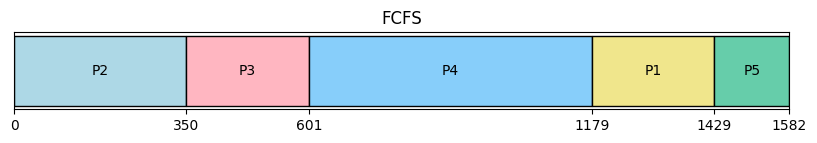

In [221]:
def FCFS(_list, _Displaying=True):
    _order = list()
    _ready_queue = list()
    # arrival_time 고려해야하니 timer 작동
    for _now_time in range(_MAX_TIME_LENGTH_):
        if (is_complete(_list) == True):
            _order.append([_NON_PROCESS_, _ALL_JOB_IS_DONE_])
            break
        # 아직 안 끝남.
        else:
            # 현재 시간에 도착해있는 작업들 리스트업
            for _process in _list:
                if _process['Arrival_time'] == _now_time:
                    _ready_queue.append(_process)
            # 도착 대기
            if _ready_queue == []:
                _order.append([_NON_PROCESS_, 1])
                pass
            # _ready_queue에 프로세스 있을 시
            else:   
                # 아무 조건 없이 0번째 process 실행시킴
                _ready_queue[0]['Burst_time'] -= 1
                _order.append([_ready_queue[0]['Num'], 1])
                if _ready_queue[0]['Burst_time'] == _COMPLETE_:
                    _ready_queue.pop(0)
                
                
    _order = order_zip(_order)
    
    if (_Displaying == True):
        _result['FCFS'] = draw(_order, 'FCFS', _Displaying)
    return _order

_list = copy.deepcopy(_DATA_)
_tmp = FCFS(_list)


## 2.2. Shortest-Job-First


### 2.2.1. SJF
- 기본 Arrival_time 정렬, 동일 시간 도착 시 프로세스 번호 순
- Arrival_time 시점 기준, Burst_time만 고려

- Order : [[2, 350], [3, 251], [1, 250], [5, 153], [4, 578], [-1, -999]]
------------------------------
ALL START GOOD JOB!!!
ALL EXIT  GOOD JOB!!!


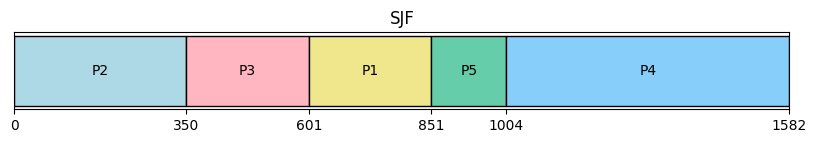

In [222]:
def SJF(_list, _Displaying=True):
    _order = list()
    _ready_queue = list()

    # arrival_time 고려해야하니 timer 작동
    for _now_time in range(_MAX_TIME_LENGTH_):
        if (is_complete(_list) == True):
            _order.append([_NON_PROCESS_, _ALL_JOB_IS_DONE_])
            break
        # 아직 안 끝남.
        else:
            # 현재 시간에 도착해있는 작업들 리스트업
            for _process in _list:
                if _process['Arrival_time'] == _now_time:
                    _ready_queue.append(_process)
                    
            if _ready_queue == []:
                _order.append([_NON_PROCESS_, 1])
                pass

            else:                
                # 만약 0초의 초기 상태나, 직전까지 대기하고 있었다면, burst_time 기준 재정렬
                if _order == [] or _order[-1][0] == _NON_PROCESS_:
                    _ready_queue.sort(key=lambda x: x['Burst_time'])
                # burst time 기준으로 정렬했으니, 맨 앞이 제일 짧은 시간 가진 것
                _ready_queue[0]['Burst_time'] -= 1
                _order.append([_ready_queue[0]['Num'], 1])
                if _ready_queue[0]['Burst_time'] == _COMPLETE_:
                    _ready_queue.pop(0)
                    # 재 스케쥴링 위해, burst time 기준 정렬하기
                    _ready_queue.sort(key=lambda x: x['Burst_time'])
    
    _order = order_zip(_order)
    if (_Displaying == True):
        _result['SJF'] = draw(_order, 'SJF', _Displaying)
    return _order


_list = copy.deepcopy(_DATA_)
_tmp = SJF(_list)


### 2.2.2. Preemptive_SJF
- 기본 Arrival_time 정렬, 동일 시간 도착 시 프로세스 번호 순
- Arrival_time 시점 기준, Burst_time만 고려
- 단, Burst_time 짧은 process 도착 시, 이것으로 대체 됨.

- Order : [[2, 78], [3, 251], [2, 171], [1, 250], [2, 50], [5, 153], [2, 51], [4, 578], [-1, -999]]
------------------------------
ALL START GOOD JOB!!!
ALL EXIT  GOOD JOB!!!


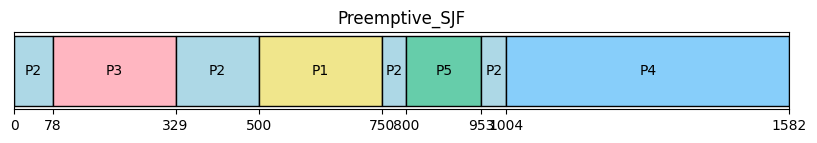

In [223]:
def Preemptive_SJF(_list, _Displaying=True):
    _order = list()
    _ready_queue = list()
    
    # arrival_time 고려해야하니 timer 작동
    for _now_time in range(_MAX_TIME_LENGTH_):
        if (is_complete(_list) == True):
            _order.append([_NON_PROCESS_, _ALL_JOB_IS_DONE_])
            break
        # 아직 안 끝남.
        else:
            # 현재 시간에 도착해있는 작업들 리스트업
            for _process in _list:
                if _process['Arrival_time'] == _now_time:
                    # priority 속성에 원래 burst time를 메모함.
                    _process['Priority'] = _process['Burst_time']
                    _ready_queue.append(_process)

            if _ready_queue == []:
                _order.append([_NON_PROCESS_, 1])
                pass

            else:
                _ready_queue.sort(key=lambda x: x['Priority'])
                # 메모한 burst time 기준으로 정렬했으니, 맨 앞이 제일 짧은 시간 가진 것
                _ready_queue[0]['Burst_time'] -= 1
                _order.append([_ready_queue[0]['Num'], 1])
                if _ready_queue[0]['Burst_time'] == _COMPLETE_:
                    _ready_queue.pop(0)
                    
    _order = order_zip(_order)
    if (_Displaying == True):
        _result['Preemptive_SJF'] = draw(_order, 'Preemptive_SJF', _Displaying)
    return _order

_list = copy.deepcopy(_DATA_)
_tmp = Preemptive_SJF(_list)


### 2.2.3. Preemptive_SRJF
- 기본 Arrival_time 정렬, 동일 시간 도착 시 프로세스 번호 순
- Arrival_time 시점 기준, 잔여 Burst_time 고려
- 단, 잔여 Burst_time 짧은 process 발견 시, 이것으로 대체 됨.

- Order : [[2, 78], [3, 251], [2, 272], [1, 250], [5, 153], [4, 578], [-1, -999]]
------------------------------
ALL START GOOD JOB!!!
ALL EXIT  GOOD JOB!!!


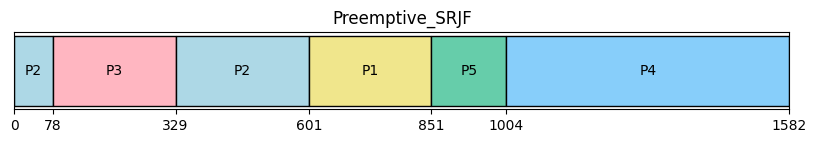

In [224]:
def Preemptive_SRJF(_list, _Displaying=True):
    _order = list()
    _ready_queue = list()

    # arrival_time 고려해야하니 timer 작동
    for _now_time in range(_MAX_TIME_LENGTH_):
        if (is_complete(_list) == True):
            _order.append([_NON_PROCESS_, _ALL_JOB_IS_DONE_])
            break
        # 아직 안 끝남.
        else:
            # 현재 시간에 도착해있는 작업들 리스트업
            for _process in _list:
                if _process['Arrival_time'] == _now_time:
                    _ready_queue.append(_process)

            if _ready_queue == []:
                _order.append([_NON_PROCESS_, 1])
                pass

            else:
                # 실시간으로 재정렬
                _ready_queue.sort(key=lambda x: x['Burst_time'])
                # burst time 기준으로 정렬했으니, 맨 앞이 제일 짧은 시간 가진 것
                _ready_queue[0]['Burst_time'] -= 1
                _order.append([_ready_queue[0]['Num'], 1])
                if _ready_queue[0]['Burst_time'] == _COMPLETE_:
                    _ready_queue.pop(0)

    _order = order_zip(_order)
    if (_Displaying == True):
        _result['Preemptive_SRJF'] = draw(_order, 'Preemptive_SRJF', _Displaying)
    return _order

_list = copy.deepcopy(_DATA_)
_tmp = Preemptive_SRJF(_list)


## 2.3. Priority First Served

### 2.3.1. Priority
- 기본 Arrival_time 정렬, 동일 시간 도착 시 프로세스 번호 순
- Priority 고려, 우선 순위 동일 시 프로세스 번호 순

- Order : [[2, 350], [3, 251], [1, 250], [5, 153], [4, 578], [-1, -999]]
------------------------------
ALL START GOOD JOB!!!
ALL EXIT  GOOD JOB!!!


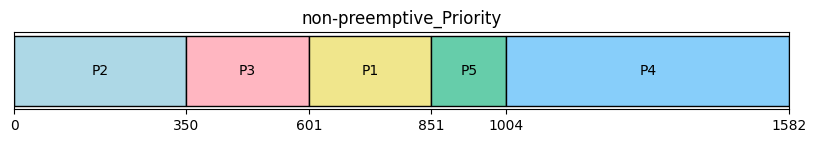

In [225]:
def Priority(_list, _Displaying=True):
    _order = list()
    _ready_queue = list()

    # arrival_time 고려해야하니 timer 작동
    for _now_time in range(_MAX_TIME_LENGTH_):
        if (is_complete(_list) == True):
            _order.append([_NON_PROCESS_, _ALL_JOB_IS_DONE_])
            break
        # 아직 안 끝남.
        else:
            # 현재 시간에 도착해있는 작업들 리스트업
            for _process in _list:
                if _process['Arrival_time'] == _now_time:
                    _ready_queue.append(_process)

            if _ready_queue == []:
                _order.append([_NON_PROCESS_, 1])
                pass

            else:
                # 만약 0초의 초기 상태나, 직전까지 대기하고 있었다면, burst_time 기준 재정렬
                if _order == [] or _order[-1][0] == _NON_PROCESS_:
                    _ready_queue.sort(key=lambda x: x['Priority'])
                # burst time 기준으로 정렬했으니, 맨 앞이 제일 짧은 시간 가진 것
                _ready_queue[0]['Burst_time'] -= 1
                _order.append([_ready_queue[0]['Num'], 1])
                if _ready_queue[0]['Burst_time'] == _COMPLETE_:
                    _ready_queue.pop(0)
                    # 재 스케쥴링 위해, burst time 기준 정렬하기
                    _ready_queue.sort(key=lambda x: x['Priority'])
                
                
    _order = order_zip(_order)
    if (_Displaying == True):
        _result['non-preemptive_Priority'] = draw(_order, 'non-preemptive_Priority', _Displaying)
    return _order

_list = copy.deepcopy(_DATA_)
_tmp = Priority(_list)


### 2.3.2. Preemptive_Priority
- 기본 Arrival_time 정렬, 동일 시간 도착 시 프로세스 번호 순
- Priority 고려, 우선 순위 동일 시 프로세스 번호 순
- 단, 더 높은 우선 순위 process 발견 시 이것으로 대체 됨.

- Order : [[2, 78], [3, 251], [2, 171], [1, 250], [2, 50], [5, 153], [2, 51], [4, 578], [-1, -999]]
------------------------------
ALL START GOOD JOB!!!
ALL EXIT  GOOD JOB!!!


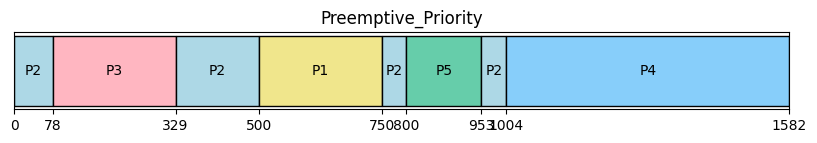

In [226]:
def Preemptive_Priority(_list, _Displaying=True):
    _order = list()
    _ready_queue = list()

    # arrival_time 고려해야하니 timer 작동
    for _now_time in range(_MAX_TIME_LENGTH_):
        if (is_complete(_list) == True):
            _order.append([_NON_PROCESS_, _ALL_JOB_IS_DONE_])
            break
        # 아직 안 끝남.
        else:
            # 현재 시간에 도착해있는 작업들 리스트업
            for _process in _list:
                if _process['Arrival_time'] == _now_time:
                    _ready_queue.append(_process)

            if _ready_queue == []:
                _order.append([_NON_PROCESS_, 1])
                pass

            else:
                _ready_queue.sort(key=lambda x: x['Priority'])
                # burst time 기준으로 정렬했으니, 맨 앞이 제일 짧은 시간 가진 것
                _ready_queue[0]['Burst_time'] -= 1
                _order.append([_ready_queue[0]['Num'], 1])
                if _ready_queue[0]['Burst_time'] == _COMPLETE_:
                    _ready_queue.pop(0)

    _order = order_zip(_order)
    if (_Displaying == True):
        _result['Preemptive_Priority'] = draw(_order, 'Preemptive_Priority', _Displaying)
    return _order


_list = copy.deepcopy(_DATA_)
_tmp = Preemptive_Priority(_list)


## 2.4. Round robin
- 기본 Arrival_time 정렬, 동일 시간 도착 시 프로세스 번호 순
- QUANTUM_TIME 내에 처리하지 못 할 경우, 남은 Burst_time은 큐의 맨 뒤로 감.

### 2.4.1. Round Robin

- Order : [[2, 80], [3, 4], [2, 4], [3, 4], [2, 4], [3, 4], [2, 4], [3, 4], [2, 4], [3, 4], [2, 4], [3, 4], [2, 4], [3, 4], [2, 4], [3, 4], [2, 4], [3, 4], [2, 4], [3, 4], [2, 4], [3, 4], [4, 4], [2, 4], [3, 4], [4, 4], [2, 4], [3, 4], [4, 4], [2, 4], [3, 4], [4, 4], [2, 4], [3, 4], [4, 4], [2, 4], [3, 4], [4, 4], [2, 4], [3, 4], [4, 4], [2, 4], [3, 4], [4, 4], [2, 4], [3, 4], [4, 4], [2, 4], [3, 4], [4, 4], [2, 4], [3, 4], [4, 4], [2, 4], [3, 4], [4, 4], [2, 4], [3, 4], [4, 4], [2, 4], [3, 4], [4, 4], [2, 4], [3, 4], [4, 4], [2, 4], [3, 4], [4, 4], [2, 4], [3, 4], [4, 4], [2, 4], [3, 4], [4, 4], [2, 4], [3, 4], [4, 4], [2, 4], [3, 4], [4, 4], [2, 4], [3, 4], [4, 4], [2, 4], [3, 4], [4, 4], [2, 4], [3, 4], [4, 4], [2, 4], [3, 4], [4, 4], [2, 4], [3, 4], [4, 4], [2, 4], [3, 4], [4, 4], [2, 4], [3, 4], [4, 4], [2, 4], [3, 4], [4, 4], [2, 4], [3, 4], [4, 4], [2, 4], [3, 4], [1, 4], [4, 4], [2, 4], [3, 4], [1, 4], [4, 4], [2, 4], [3, 4], [1, 4], [4, 4], [2, 4], [3, 4], [1, 4], [4, 4], [2, 

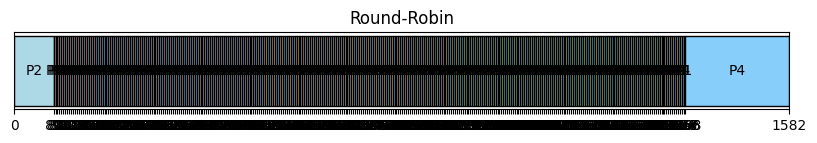

In [227]:
def RR(_list, _Displaying=True, _usr_quantum_time=_DEFAULT_QUANTUM_TIME_):
    _order = list()
    _ready_queue = list()
    _QUANTUM_TIME_ = _usr_quantum_time
    
    _remain_quantum_time = _QUANTUM_TIME_
    
    # arrival_time 고려해야하니 timer 작동
    for _now_time in range(_MAX_TIME_LENGTH_):
        if (is_complete(_list) == True):
            _order.append([_NON_PROCESS_, _ALL_JOB_IS_DONE_])
            break
        # 아직 안 끝남.
        else:
            # 현재 시간에 도착해있는 작업들 리스트업
            for _process in _list:
                if _process['Arrival_time'] == _now_time:
                    _ready_queue.append(_process)

            if _ready_queue == []:
                _order.append([_NON_PROCESS_, 1])
                pass
            else:
                if _remain_quantum_time == _COMPLETE_:
                    _remain_quantum_time = _QUANTUM_TIME_
                # 그리고 오더 1초씩 추가
                _order.append([_ready_queue[0]['Num'], 1])
                # 남은 burst_time 1초 삭감
                _ready_queue[0]['Burst_time'] -= 1
                # 남은 오더 가능 횟수 1회 삭감
                _remain_quantum_time -= 1
                # 만약 몇초 안 남아서 퀀텀타임보다 일찍 끝나면?
                if (_ready_queue[0]['Burst_time'] == _COMPLETE_):
                    # 기능종료와 큐에서 삭제
                    _ready_queue.pop(0)
                    _remain_quantum_time = _COMPLETE_
                # 만약 퀀텀타임을 다 사용하면?
                elif (_remain_quantum_time == 0):
                    # 큐의 맨 뒤로 돌려보냄
                    _ready_queue.append(_ready_queue.pop(0))

    _order = order_zip(_order)
    if (_Displaying == True):
        _result['Round-Robin'] = draw(_order, 'Round-Robin', _Displaying)
    return _order

_list = copy.deepcopy(_DATA_)
_tmp = RR(_list, True, _DEFAULT_QUANTUM_TIME_)


### 2.4.2. Priority + Round robin
- 기본 Arrival_time 정렬, 동일 시간 도착 시 프로세스 번호 순
- QUANTUM_TIME 내에 처리하지 못 할 경우, 남은 Burst_time은 큐의 맨 뒤로 감.
- Priority 고려, 우선 순위 동일 시 프로세스 번호 순

- Order : [[2, 80], [3, 251], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [1, 250], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [5, 153], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4], [4, 4], [2, 4]

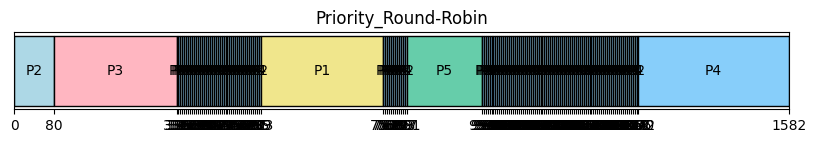

In [228]:
def Priority_RR(_list, _Displaying=True, _usr_quantum_time=_DEFAULT_QUANTUM_TIME_):
    _order = list()
    _ready_queue = list()
    _QUANTUM_TIME_ = _usr_quantum_time

    _remain_quantum_time = _QUANTUM_TIME_

    # arrival_time 고려해야하니 timer 작동
    for _now_time in range(_MAX_TIME_LENGTH_):
        if (is_complete(_list) == True):
            _order.append([_NON_PROCESS_, _ALL_JOB_IS_DONE_])
            break
        # 아직 안 끝남.
        else:
            # 현재 시간에 도착해있는 작업들 리스트업
            for _process in _list:
                if _process['Arrival_time'] == _now_time:
                    _ready_queue.append(_process)

            if _ready_queue == []:
                _order.append([_NON_PROCESS_, 1])
                pass
            else:
                if _remain_quantum_time == _COMPLETE_:
                    _ready_queue.sort(key=lambda x: x['Priority'])
                    _remain_quantum_time = _QUANTUM_TIME_
                # 그리고 오더 1초씩 추가
                _order.append([_ready_queue[0]['Num'], 1])
                # 남은 burst_time 1초 삭감
                _ready_queue[0]['Burst_time'] -= 1
                # 남은 오더 가능 횟수 1회 삭감
                _remain_quantum_time -= 1
                # 만약 몇초 안 남아서 퀀텀타임보다 일찍 끝나면?
                if (_ready_queue[0]['Burst_time'] == _COMPLETE_):
                    # 기능종료와 큐에서 삭제
                    _ready_queue.pop(0)
                    _remain_quantum_time = _COMPLETE_
                # 만약 퀀텀타임을 다 사용하면?
                elif (_remain_quantum_time == 0):
                    # 큐의 맨 뒤로 돌려보냄
                    _ready_queue.append(_ready_queue.pop(0))
                    
                    
    _order = order_zip(_order)
    if (_Displaying == True):
        _result['Priority_Round-Robin'] = draw(_order,
                                               'Priority_Round-Robin', _Displaying)
    return _order

_list = copy.deepcopy(_DATA_)
_tmp = Priority_RR(_list, True, _DEFAULT_QUANTUM_TIME_)


## 2.5. Multi Level Queue
- 스케줄링 함수 호출 시, 2번째 파라미터로 False 주면 출력 아예 없음.

### 2.5.1. Multi Level Queue


- Order : [[2, 78], [3, 251], [2, 171], [1, 250], [2, 50], [5, 153], [2, 51], [4, 578], [-1, -999]]
------------------------------
ALL START GOOD JOB!!!
ALL EXIT  GOOD JOB!!!


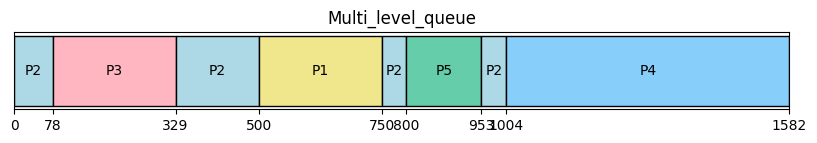

In [229]:
def Multi_level_queue(_list, _quantum_time):
    _order = list()
    # 서로다른 priority 갯수 세기
    _unique_priorities = set()
    for process in _list:
        _unique_priorities.add(process['Priority'])
    # index 나중에 필요해서 list로 전환
    _unique_priorities = list(_unique_priorities)
    _unique_priorities = sorted(_unique_priorities)
    # create level empty queue
    _level = list()
    # print(_unique_priorities)
    for i in range(len(_unique_priorities)):
        _level.append([])
        # 동일 레벨 갯수대로 각각 level_queue 생성하기
    
    for _target_priority in _unique_priorities:
        for i in range(len(_list)):
            if (_list[i]['Priority'] == _target_priority):
                _level[_unique_priorities.index(
                    _target_priority)].append(_list[i])
    
    #####################################################################    
    ## 각자 레벨에서 각기 다른 방식으로 스케쥴링 된 것들이, 선점형 우선순위 스케쥴링 되어야함.
    # each level scheduling
    _level_complete = list()
    for i in range(len(_level)):
        if(i == 0):
            _level_complete.append(Priority_RR(
                _level[i], False, _quantum_time))
        elif(i == 1):
            _level_complete.append(Priority_RR(
                _level[i], False, _quantum_time))
        elif (i == 2):
            _level_complete.append(Preemptive_SRJF(_level[i], False))
        elif (i == 3):
            _level_complete.append(Preemptive_SRJF(_level[i], False))
        elif (i == 4):
            _level_complete.append(SJF(_level[i], False))
        else:
            _level_complete.append(FCFS(_level[i], False))
    
    #####################################################################
    ### 우선순위 기반 큐 간 스케쥴링 
    for _now_time in range(_MAX_TIME_LENGTH_):

        
        # 하위 우선순위부터 _now_time에 실행할 것을 갱신함.
        # 제일 마지막에 갱신된 것이 가장 높은 우선순위 & 실행가능한 프로세스임.
        _now_order = [_NON_PROCESS_, 1]
        for _each_level in reversed(_level_complete):
            # 맨 앞이 무엇이든, 0초 남은 complete면 삭제
            if (_each_level[0][1] == _COMPLETE_):
                _each_level.pop(0)
            # 만약 대기 플래그였다면 ? 대기 시간 1초 진행 (삭감)
            if (_each_level[0][0] == _NON_PROCESS_):
                _each_level[0][1] -= 1    
            # queue의 맨 앞이 프로세스고, 진행 가능하면 진행할 것임
            else:
                # _now_order[0]은 process number임
                _now_order[0] = _each_level[0][0]
        # 만약 모두 대기시간이라면, _now_order == [_NON_PROCESS_, 1] 그대로일 것,
        # 만약 최우선 우선순위 프로세스 탐지되면, _now_order == [NUMBER, 1] 로 변경되었을 것.
        ##################################################
        # 그런데 만약 모든 레벨에서 작업 종료되었다면, [_NON_PROCESS, _ALL_JOB_IS_DONE_] 에서 
        # _ALL_JOB_IS_DONE_ -= 1 이 누적된 종료 플래그만 남아있을 것.
        _end_flag = True
        # 만약 모든 레벨에서 유효한 잔여 burst_time 하나라도 발견되면? 종료 취소
        for _each_level in _level_complete:
            if (_each_level[0][1] > _ALL_JOB_IS_DONE_):
                _end_flag = False
        # 모든 레벨 검사 후, 엔드 플래그 변경 없으면, 전체 스케쥴링 종료 플래그 삽입
        if (_end_flag == True):
            break
        ##################################################
        # 만약 정해진 것이 _NON_PROCESS라면 pass
        if _now_order == [_NON_PROCESS_, 1]:
            _order.append(_now_order)
            
        # 만약 정해진 것이 PROCESS라면 그 number process 찾아서 -1 시키기
        else:
            for _each_level in _level_complete:
                # 해당 프로세스 찾을 시
                if (_now_order[0] == _each_level[0][0]):
                    _each_level[0][1] -= 1
                    _order.append(_now_order)
                    break

            
    _order.append([_NON_PROCESS_, _ALL_JOB_IS_DONE_])
    # order 압축
    _order = order_zip(_order)
    _result['Multi_level_queue'] = draw(_order, 'Multi_level_queue', True)

_list = copy.deepcopy(_DATA_)
Multi_level_queue(_list, 30)


### 2.5.2. Multi Level Feedback Queue

case 2에서 1번 bursttime 25주면 8, 16하고 1따로 해야하는데, 두번째 점유에서 17s 진행됨.
버그 잡아야함

- Order : [[2, 130], [3, 40], [4, 40], [2, 220], [3, 90], [1, 40], [4, 90], [3, 121], [1, 90], [5, 40], [4, 448], [1, 120], [5, 113], [-1, -999]]
------------------------------
ALL START GOOD JOB!!!
ALL EXIT  GOOD JOB!!!


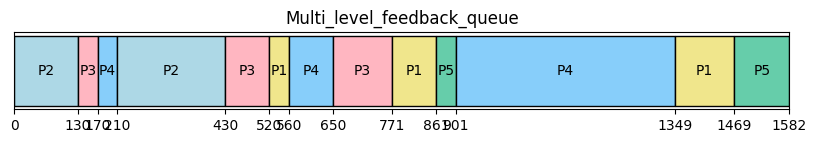

In [230]:
def is_empty_list(_levels):
    is_empty = True
    for i in range(len(_levels)):
        if _levels[i]:
            is_empty = False
            break
    return is_empty

def Multi_level_feedback_queue(_list, _level1 = 8, _level2 = 16):
    _order = list()

    # 각 quantum 8, 16, FCFO
    _levels = [[],[],[]]
    _LEVEL_1_QUANTUM_TIME_ = _level1
    _LEVEL_2_QUANTUM_TIME_ = _level2
    #####################################################################
    # 우선순위 기반 큐 간 스케쥴링
    for _now_time in range(_MAX_TIME_LENGTH_):
        if (is_complete(_list) == True):
            _order.append([_NON_PROCESS_, _ALL_JOB_IS_DONE_])
            break
        # 현재 시간에 도착해있는 작업들 리스트업
        for _process in _list:
            if (_process['Arrival_time'] == _now_time):
                _levels[0].append(_process)
                # priority에 부여된 퀀텀타임 메모함
                _levels[0][-1]['Priority'] = _levels[0][-1]['Burst_time']
                # Period에 스케쥴링 횟수 메모함. 0번이면 최초 퀀텀, 1번이면 둘째 퀀텀, 세번이면 FCFS 배정.
                _levels[0][-1]['Period'] = 0
                if (_levels[0][-1]['Burst_time'] < _LEVEL_1_QUANTUM_TIME_):
                    pass
                else:
                    _levels[0][-1]['Burst_time'] = _LEVEL_1_QUANTUM_TIME_
        ###############################################################
        # 하나도 도착 안 했으면 >> wait
        if (is_empty_list(_levels) == True):
            _order.append([_NON_PROCESS_, 1])
            pass
        # 기본 세팅 끝. 이하 levels 존재 가정함.
        else:
            ###########################
            # 첫 레벨에 없는 경우
            while _levels[0] == []:
                # 둘째 레벨에도 없는 경우
                while _levels[1] == []:
                    _levels[1].append(_levels[2].pop(0))
                    _levels[1][0]['Burst_time'] = _levels[1][0]['Priority']
                # 둘째 레벨까지 채워 넣었음.
                _levels[0].append(_levels[1].pop(0))
                if (_levels[0][0]['Period'] == 2):
                    _levels[0][0]['Burst_time'] = _levels[0][0]['Priority']
                    pass
                else:
                    _levels[0][0]['Burst_time'] = _LEVEL_2_QUANTUM_TIME_
            ######## 대기는 위에서 예외처리했으니, 무조건 1단계에 process 존재함.
            _now_process = _levels[0][0]
            
            # 할당 시간 오더에 추가하고
            _order.append([_now_process['Num'], 1])
            # 일단 시간 줄이고 다음 큐에 대입
            _now_process['Burst_time'] -= 1
            _now_process['Priority'] -= 1
            
            
            # 배정시간 끝난 경우, 아래 레벨로 강등
            if (_now_process['Priority'] > 0 and _now_process['Burst_time'] == 0):
                # 여기서 burst time = 0 해버리면, is complete 함수에서 전체 종료로 인식하기에,
                # 임의의 이상한 숫자 넣어둠
                _now_process['Burst_time'] = -987654321
                _levels[0][0]['Period'] += 1
                _levels[1].append(_levels[0].pop(0))
            # 빈 프로세서 발견하면 다 치워버리고 카운터 초기화
            elif (_now_process['Priority'] == 0):
                _now_process['Burst_time'] = 0
                _levels[0].pop(0)
        # print(_now_time, _levels[0])
        # print(_now_time, _levels[1])
        # print(_now_time, _levels[2])
        # print('-')
    
    _order = order_zip(_order)
    _result['Multi_level_feedback_queue'] = draw(_order, 'Multi_level_feedback_queue', True)

_list = copy.deepcopy(_DATA_)
# 2, 3번째 parameter로 퀀텀타임 배정하는 것 수정 가능.
Multi_level_feedback_queue(_list, 40, 90)


-------------------------------------

## 결과 분석

- Benchmark Rule

    - 1순위 비교 값 : 평균 대기 시간 (Average_waiting_time) 낮은 것.
    - 2순위 비교 값 : 평균 총 처리 시간 (Average_Turnaround_time) 낮은 것.
    - 3순위 비교 값 : 평균 응답 시간 (Average_Response_time) 낮은 것.
    - 4순위 비교 값 : CPU 이용률 (CPU_utilization) 높은 것.
    - 5순위 비교 값 : 처리율 (Throughput) 높은 것.

In [231]:
import pandas as pd

df = pd.DataFrame(_result)
df = df.transpose()
_sort_priority_list = ['Average_waiting_time', \
                        'Average_Turnaround_time', \
                            'Average_Response_time', \
                                'CPU_utilization', \
                                    'Throughput']
# True == 오름차순, False == 내림차순
df.sort_values(by=_sort_priority_list, ascending=[True, True, True, False, False], inplace=True)


print('---------Deterministic Benchmark Result---------')
print('- The best scheduling solution for json file[', _JSON_NUM_, ']')
print('>>', df.index[0])    
print('------------------------------------------------')

# 출력 결과는 0번일테니, 1번부터 비교
_same_result_cnt = 0
for i in range(1, len(_result)):
    _same_flag = 0
    _idx = 0
    while(df[df.columns[_idx]][df.index[i]] == df[df.columns[_idx]][df.index[0]]):
        if(_idx == 4):
            break
        _idx += 1
        _same_flag += 1
    if(_same_flag > 0):
        if(_same_flag == 4):
            _same_result_cnt += 1
        print('- 단,', df.index[i],'도,', _same_flag+1, '순위 까지 같음.')
if(_same_result_cnt != 0):
    print('>> 5순위 비교 결과까지 같은', _same_result_cnt,'가지 방법으로 대체 가능함.')
else:
    print('>> 전체 스케쥴링 간 최고 우위인,', df.index[0],'는 벤치마크가 가장 좋은 스케쥴링임.')
print('------------------------------------------------')      
    
# - 5순위까지 일치 시, 동일한 성능이라고 판단.
# - 4순위까지 일치해도, 5순위 다르면 최고 우위 스케쥴링 선정할 수 있음.
df


---------Deterministic Benchmark Result---------
- The best scheduling solution for json file[ 2 ]
>> SJF
------------------------------------------------
- 단, non-preemptive_Priority 도, 5 순위 까지 같음.
>> 5순위 비교 결과까지 같은 1 가지 방법으로 대체 가능함.
------------------------------------------------


,Average_waiting_time,Average_Turnaround_time,Average_Response_time,CPU_utilization,Throughput
SJF,561.2,570.4,561.2,100.0,0.003161
non-preemptive_Priority,561.2,570.4,561.2,100.0,0.003161
Preemptive_SRJF,572.6,566.2,506.8,100.0,0.003161
FCFS,711.8,721.0,711.8,100.0,0.003161
Preemptive_SJF,882.8,616.4,476.4,100.0,0.003161
Preemptive_Priority,882.8,616.4,476.4,100.0,0.003161
Multi_level_queue,882.8,616.4,476.4,100.0,0.003161
Multi_level_feedback_queue,1604.2,813.0,336.2,100.0,0.003161
Priority_Round-Robin,23752.2,671.2,343.8,100.0,0.003161
Round-Robin,47249.4,924.8,314.4,100.0,0.003161


-------------------------

# 3.Real-Time scheduling

## 3.1. Rate-Monotonic
- period가 짧은 프로세스가 높은 우선순위를 가짐.
- 단위 시간 당, 프로세스의 수행 비율과 우선순위 간의 관계를 고려함
- 모든 프로세스는 부팅과 동시에 주기를 갖고 실행된다고 가정 -> 오로지 Burst_time과 period만 필요.

- Order : [[1, 250], [5, 153], [3, 97], [1, 250], [5, 153], [3, 97], [1, 250], [3, 57], [2, 93], [5, 100], [1, 250], [5, 53], [2, 197], [1, 250], [5, 153], [2, 60], [4, 37], [1, 250], [4, 50], [5, 153], [4, 47], [1, 250], [4, 250], [1, 250], [5, 153], [4, 97], [1, 250], [5, 153], [4, 97], [1, 250], [-1, 150], [5, 100], [1, 250], [5, 53], [-1, 197], [1, 250], [5, 153], [-1, 97], [1, 250], [-1, 50], [5, 153], [-1, 47], [1, 250], [-1, 250], [1, 250], [5, 153], [3, 97], [1, 250], [5, 153], [3, 97], [1, 250], [3, 57], [2, 93], [5, 100], [1, 250], [5, 53], [2, 197], [1, 250], [5, 153], [2, 60], [4, 37], [1, 250], [4, 50], [5, 153], [4, 47], [1, 250], [4, 250], [1, 250], [5, 153], [4, 97], [1, 250], [5, 153], [4, 97], [1, 250], [-1, 150], [5, 100], [1, 250], [5, 53], [-1, 197], [1, 250], [5, 153], [-1, 97], [1, 250], [-1, 50], [5, 153], [-1, 47], [1, 250], [-1, 250], [1, 250], [5, 153], [3, 97], [1, 250], [5, 153], [3, 97], [1, 250], [3, 57], [-1, 93], [5, 100], [1, 250], [5, 53], [-1, 197], 

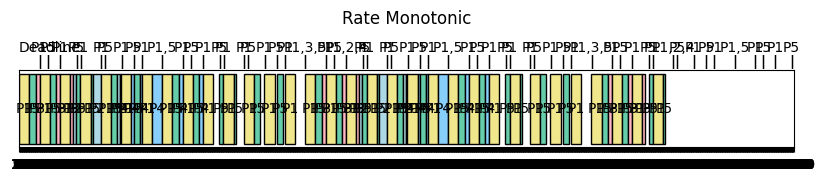

In [232]:
def Rate_Monotonic(_list):
    # burst_time copy
    _original_list = copy.deepcopy(_list)
    # 완료 판단할 것인데, index 기반 접근 위해 num 기준 sort
    _original_list = sorted(_original_list, key=lambda x: x['Num'])
    _pass_list = set()
    # rate-monotonic이 성립할지?
    # 각자 모두가 0초부터 자신의 period 내에 1번이라도 실행되었는가 판단하면 됨.
    # can_to_this에서 period와 now_time을 비교하는데, burst_time 남아있으면 다 못한 것
    _order = []

    # _period_vector는 우선순위로 정렬해서 줘야함.
    _period_vector = []
    _jop_complete_alram_vector = []

    # 가장 긴 주기 2배 만큼 플로팅
    _periods = []
    for _process in _list:
        _period_vector.append([_process['Num'], _process['Period']])
        _periods.append(_process['Period'])

    for _now_time in range(max(_periods)*2):

        # period 주기가 도래할 때마다 그 프로세서를 큐에 추가함
        for _process in _original_list:
            if (_now_time % _process['Period'] == 0 and _now_time > 0):
                _add_this_jop = copy.deepcopy(_process)
                _list.append(_add_this_jop)

        # period에 기반한 우선순위 설정
        if (_list == []):
            # 비어있을 시 대기시간 추가
            _order.append([_NON_PROCESS_, 1])
            continue
        else:
            # 우선순위 별 정렬
            _list = sorted(_list, key=lambda x: x['Period'])
            # 오더 추가
            _order.append([_list[0]['Num'], 1])
            # 진행 상황 반영
            _list[0]['Burst_time'] -= 1
            # 모두 진행 되었으면, 큐에서 삭제
            if (_list[0]['Burst_time'] == 0):
                _jop_complete_alram_vector.append([_list[0]['Num'], _now_time])
                _list.pop(0)

        # 주기 안에 실행완료 성공했는지 확인하는 코드
        for _complete_process, _when in _jop_complete_alram_vector:
            # 1 주기 돌았을 때에만 검사함.
            # 만약 그게 pass list에 없으면
            if _complete_process not in _pass_list:
                # 근데 완료 시점이 추기보다 짧으면
                if (_when <= _original_list[_complete_process-1]['Period']):
                    # pass 확인요
                    _pass_list.add(_complete_process)
                    pass
                # 근데 추기보다 길다면, 걔때문에 rate-monotonic 불가
                else:
                    print("CAN'T TO THIS..", "Force exit..")
                    print('now_time :', _now_time)
                    print("running failed process :", _complete_process)
                    return
    # 종료 플래그 삽입
    _order.append([_NON_PROCESS_, _ALL_JOB_IS_DONE_])
    _order = order_zip(_order)

    
    draw(_order, 'Rate Monotonic',  True,_period_vector)


_list = copy.deepcopy(_DATA_)
Rate_Monotonic(_list)

##########################
# 만약 모든 프로세스들이 첫 period 내에 1회 이상 완전히 실행되지 않는 경우,
# print("CAN'T TO THIS")와 바로 return 하며 종료



In [233]:
# 최소공배수 찾는 함수
from math import gcd
def lcm_solution(arr):
    def lcm(x, y):
        return x * y // gcd(x, y)

    while True:
        arr.append(lcm(arr.pop(), arr.pop()))
        if len(arr) == 1:
            return arr[0]

## 3.2. EDF (Earliest Deadline First)

LCM == 56000
P 1 : 56000 divided by 500 = 112 . and cnt == 112 . OK.
P 2 : 56000 divided by 8000 = 7 . and cnt == 7 . OK.
P 3 : 56000 divided by 7000 = 8 . and cnt == 8 . OK.
P 4 : 56000 divided by 8000 = 7 . and cnt == 7 . OK.
P 5 : 56000 divided by 700 = 80 . and cnt == 80 . OK.
- Order : [[1, 250], [5, 153], [3, 97], [1, 250], [5, 153], [3, 97], [1, 250], [3, 57], [2, 93], [5, 100], [1, 250], [5, 53], [2, 197], [1, 250], [5, 153], [2, 60], [4, 37], [1, 250], [4, 50], [5, 153], [4, 47], [1, 250], [4, 250], [1, 250], [5, 153], [4, 97], [1, 250], [5, 153], [4, 97], [1, 250], [-1, 150], [5, 100], [1, 250], [5, 53], [-1, 197], [1, 250], [5, 153], [-1, 97], [1, 250], [-1, 50], [5, 153], [-1, 47], [1, 250], [-1, 250], [1, 250], [5, 153], [3, 97], [1, 250], [5, 153], [3, 97], [1, 250], [3, 57], [2, 93], [5, 100], [1, 250], [5, 53], [2, 197], [1, 250], [5, 153], [2, 60], [4, 37], [1, 250], [4, 50], [5, 153], [4, 47], [1, 250], [4, 250], [1, 250], [5, 153], [4, 97], [1, 250], [5, 153], [4, 97

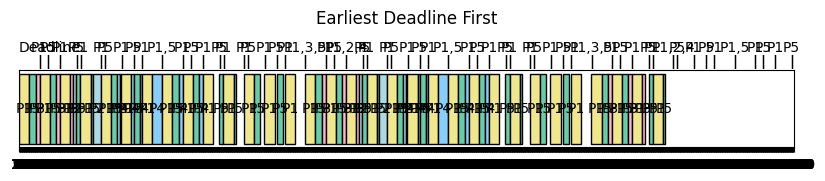

In [234]:
def EDF(_list):
    # burst_time copy
    _original_list = copy.deepcopy(_list)
    # 완료 판단할 것인데, index 기반 접근 위해 num 기준 sort
    _original_list = sorted(_original_list, key=lambda x: x['Num'])
    
    _order = []

    # _period_vector는 우선순위로 정렬해서 줘야함.
    _period_vector = []
    # _jop_complete_alram_vector = []
    

    # 가장 긴 주기 2배 만큼 플로팅
    _periods = []
    _complete_counter = []
    for _process in _list:
        _period_vector.append([_process['Num'], _process['Period']])
        _complete_counter.append(0)
        _periods.append(_process['Period'])
    
    _max_period = max(_periods)*2
    
    
    # 최소공배수 구하기
    _lcm = lcm_solution(_periods)
    
    if (_MAX_TIME_LENGTH_ < _lcm):
        print("계산 보증 불가능. 주기들의 최소공배수 시간에서 정상횟수 작동 확인 불가. MAX_TIME_LENGTH 늘리고 다시시도.")
        print(_lcm, "여기까지 시도해봐야 정확히 RTOS 구현 가능 여부 알 수 있음.")
    
    for _now_time in range(max(_periods)*2):

        # period 주기가 도래할 때마다 그 프로세서를 큐에 추가함
        for _process in _original_list:
            if (_now_time % _process['Period'] == 0 and _now_time > 0):
                _add_this_jop = copy.deepcopy(_process)
                _list.append(_add_this_jop)

        # period에 기반한 우선순위 설정
        if (_list == []):
            # 비어있을 시 대기시간 추가
            if (_now_time < _max_period):
                _order.append([_NON_PROCESS_, 1])
            
        else:
            # 우선순위 별 정렬
            _list = sorted(_list, key=lambda x: x['Period'])
            ###################################
            # 데드라인 얼마 안 남은 놈을 _list 맨 앞으로 보내면 됨.
            # 1. 데드라인 제일 가까운 놈을 구해야함.
            _i_want_complete = 0
            _min_remain_time = _MAX_TIME_LENGTH_
            # 모든 list의 프로세스에서
            for _process in _list:
                # dead_line까지 남은 시간 구하기
                _remain_time = (_process['Period'] - _now_time % _process['Period'])
                # 이번 process의 dead_line이 가장 짧았다면 갱신
                if (_remain_time < _min_remain_time):
                    _min_remain_time = _remain_time
                    _i_want_complete = _process
                # print(_now_time, _remain_time, _process)
            # 2. 걔만 맨 앞으로. (데드라인 순 정렬 안 해도, 어차피 매 순간 적게 남은 프로세스만 앞으로 옴)
            _list.remove(_i_want_complete)
            _list.insert(0, _i_want_complete)
            ###################################
            # 오더 추가
            if (_now_time < _max_period):
                _order.append([_list[0]['Num'], 1])
            # 진행 상황 반영
            _list[0]['Burst_time'] -= 1
            # 모두 진행 되었으면, 큐에서 삭제
            if (_list[0]['Burst_time'] == 0):
                # if (_now_time < _max_period):
                #     _jop_complete_alram_vector.append([_list[0]['Num'], _now_time])
                _complete_counter[_list[0]['Num']-1] += 1
                _list.pop(0)

        # 최소공배수 안에 완료가능한가.
        if (_now_time == _lcm):
            print("LCM ==", _now_time)
            for _process in _original_list:
                if (_now_time / _process['Period'] <= _complete_counter[_process['Num']-1]):
                    print("P", _process['Num'], ':', _lcm, "divided by", _process['Period'], '=', int(
                        _now_time / _process['Period']), ". and cnt ==", _complete_counter[_process['Num']-1], ". OK.")
                else:
                    print("P", _process['Num'], ':', "CAN'T DO THIS..", "Force exit..")
                    return

    # 종료 플래그 삽입
    _order.append([_NON_PROCESS_, _ALL_JOB_IS_DONE_])
    _order = order_zip(_order)
    
    draw(_order, 'Earliest Deadline First', True, _period_vector)

_list = copy.deepcopy(_DATA_)
EDF(_list)

#######################
# 해당 스케쥴링 불가한 경우, 진행 불가하단 메시지 출력함.
